In [1]:
from zipfile import ZipFile
import pandas
import seaborn as sns
from io import BytesIO
import requests
import urllib.request

In [2]:
%matplotlib inline 

In [3]:
result = requests.get("https://www.covid19.admin.ch/api/data/20220117-ylc277il/downloads/sources-csv.zip")

In [4]:
zf = ZipFile(BytesIO(result.content))

dfs = dict()
for item in zf.namelist():
    if item.endswith('.csv'):
        df = pandas.read_csv(zf.open(item), encoding='latin-1', error_bad_lines=False, low_memory=False)
        dfs[item] = df


In [5]:
df_hosp_capacity = dfs['data/COVID19HospCapacity_geoRegion.csv']
df_hosp_ch = df_hosp_capacity[['date', 'geoRegion', 'ICU_NonCovid19Patients', 'ICU_Covid19Patients',
       'ICU_Capacity', 'Total_NonCovid19Patients', 'Total_Covid19Patients',
       'Total_Capacity']][df_hosp_capacity['geoRegion'] == 'CH']

#df_hosp_ch = df_hosp_ch.loc[df_hosp_capacity['type_variant'] == 'fp7d']
df_hosp_ch = df_hosp_ch.loc[df_hosp_capacity['type_variant'] == 'nfp']

df_hosp_ch['Total_NonCovid19Patients'] = df_hosp_ch['Total_NonCovid19Patients'].ffill()
df_hosp_ch['Total_Covid19Patients'] = df_hosp_ch['Total_Covid19Patients'].ffill()

df_hosp_ch_total = df_hosp_ch[['date', 'geoRegion', 'Total_NonCovid19Patients', 'Total_Covid19Patients', 'Total_Capacity']]
df_hosp_ch_total.insert(0, 'Total', df_hosp_ch_total['Total_NonCovid19Patients'].add(df_hosp_ch_total['Total_Covid19Patients']))

df_hosp_ch_total_2020 = df_hosp_ch_total[
    (df_hosp_ch_total['date'] <= '2020-31-12')
    & (df_hosp_ch_total['date'] > '2019-31-12')]

df_hosp_ch_total_2021 = df_hosp_ch_total[
    (df_hosp_ch_total['date'] <= '2021-31-12')
    & (df_hosp_ch_total['date'] > '2020-31-12')]

df_hosp_ch_total_2020.insert(0, 'dayOfYear', pandas.to_datetime(df_hosp_ch_total_2020['date']).dt.strftime('%m-%d'))
df_hosp_ch_total_2021.insert(0, 'dayOfYear', pandas.to_datetime(df_hosp_ch_total_2021['date']).dt.strftime('%m-%d'))

In [6]:
df_hosp_ch_total_2021

,dayOfYear,Total,date,geoRegion,Total_NonCovid19Patients,Total_Covid19Patients,Total_Capacity
34493,01-01,2417.0,2021-01-01,CH,10080.0,2417.0,20477.0
34494,01-02,2472.0,2021-01-02,CH,10355.0,2472.0,20825.0
34495,01-03,2568.0,2021-01-03,CH,10738.0,2568.0,20875.0
34496,01-04,2500.0,2021-01-04,CH,12199.0,2500.0,21890.0
34497,01-05,2649.0,2021-01-05,CH,13234.0,2649.0,21900.0
...,...,...,...,...,...,...,...
34853,12-27,1667.0,2021-12-27,CH,12871.0,1667.0,21586.0
34854,12-28,1678.0,2021-12-28,CH,13754.0,1678.0,21981.0
34855,12-29,1731.0,2021-12-29,CH,13869.0,1731.0,22214.0
34856,12-30,1653.0,2021-12-30,CH,13646.0,1653.0,22141.0


In [7]:
from matplotlib import pyplot
pyplot.rcParams['figure.figsize'] = [20, 10]
pyplot.rcParams.update({'font.size': 22})

In [8]:
df_2020 = df_hosp_ch_total_2020.set_index('dayOfYear', inplace=False).rolling(window=14).mean()['Total']
df_2021 = df_hosp_ch_total_2021.set_index('dayOfYear', inplace=False).rolling(window=14).mean()['Total']
df_2020.name = 'Hospitalisations 2020'
df_2021.name = 'Hospitalisations 2021'
output = pandas.DataFrame([df_2020, df_2021]).transpose().sort_index(inplace=False)

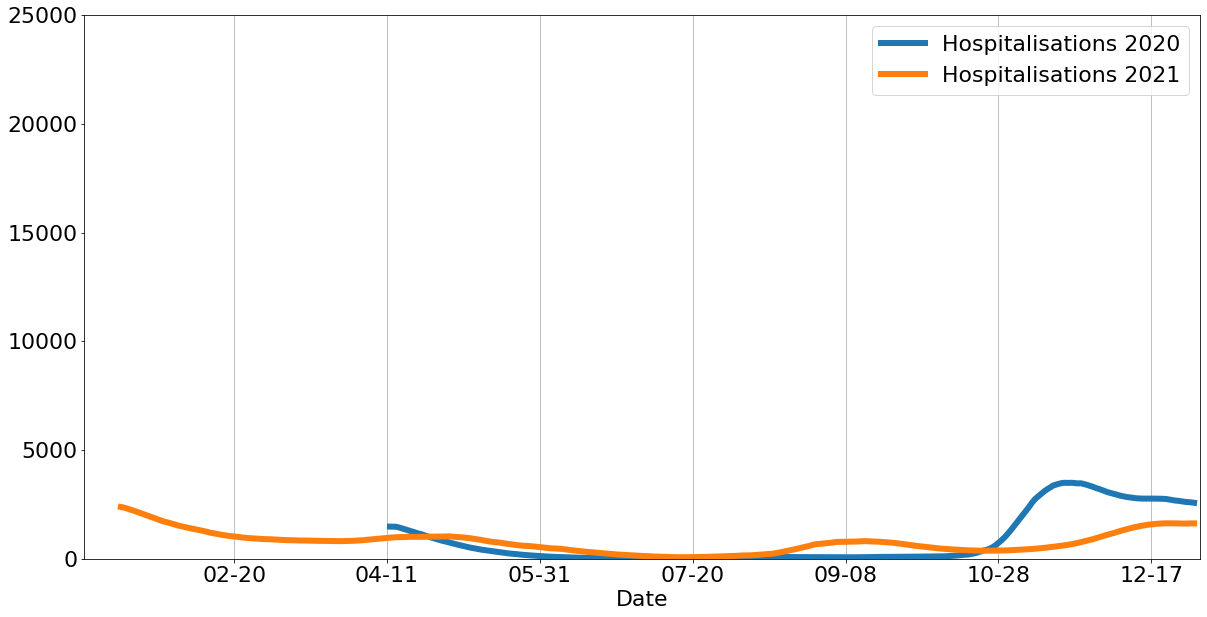

In [9]:
chart = output.plot(kind='line', xlim=(1, 366), ylim=(0, 25000), xlabel='Date', linewidth=6)
chart.grid(axis='x')

In [25]:
test_2020 = df_hosp_capacity[['date', 'geoRegion', 'ICU_NonCovid19Patients', 'ICU_Covid19Patients',
       'ICU_Capacity', 'Total_NonCovid19Patients', 'Total_Covid19Patients',
       'Total_Capacity', 'type_variant']][df_hosp_capacity['geoRegion'] == 'CH'][
    (df_hosp_capacity['date'] <= '2020-31-12')
    & (df_hosp_capacity['date'] > '2019-31-12')]

test_2021 = df_hosp_capacity[['date', 'geoRegion', 'ICU_NonCovid19Patients', 'ICU_Covid19Patients',
       'ICU_Capacity', 'Total_NonCovid19Patients', 'Total_Covid19Patients',
       'Total_Capacity', 'type_variant']][df_hosp_capacity['geoRegion'] == 'CH'][
    (df_hosp_capacity['date'] <= '2021-31-12')
    & (df_hosp_capacity['date'] > '2020-31-12')]


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [33]:
test_2020_nfp = test_2020[test_2020['type_variant'] == 'nfp']
test_2021_nfp = test_2021[test_2021['type_variant'] == 'nfp']
test_2020_fp7d = test_2020[test_2020['type_variant'] == 'fp7d']
test_2021_fp7d = test_2021[test_2021['type_variant'] == 'fp7d']

In [35]:
(test_2020_nfp['Total_NonCovid19Patients'] + test_2020_nfp['Total_Covid19Patients']).sum()

2842562.0

In [36]:
(test_2021_nfp['Total_NonCovid19Patients'] + test_2021_nfp['Total_Covid19Patients']).sum()

5781242.0

In [37]:
(test_2020_fp7d['Total_NonCovid19Patients'] + test_2020_fp7d['Total_Covid19Patients']).sum()

3828505.0

In [38]:
(test_2021_fp7d['Total_NonCovid19Patients'] + test_2021_fp7d['Total_Covid19Patients']).sum()

6279971.0